In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import seaborn as sns
import json
import torch
import pickle

import matplotlib
matplotlib.rcParams.update({'font.size': 14})
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DeJavu Serif"


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-sk4dhl0z because the default path (/afs/cs.stanford.edu/u/mfchen/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
df_all = pd.DataFrame()

In [2]:
perp_folders = ["../output/10162023/", "../output/10172023/"]

In [4]:

for perp_folder in perp_folders:
    files = os.listdir(perp_folder)
    files = [os.path.join(perp_folder, f) for f in files] # add path to each file
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    
    for file in files:        
        if "opposite" in file or "emb" in file or "predictions" in file or "proportions" in file or "labels" in file or "curriculum.pkl" in file:
            continue 
                
        if ".log" in file:
            continue
        method = file.split("/")[-1]
        
        runs = os.listdir(file)
        
        for run in runs:
            if "labels" in run or "curriculum" in run or "proportions" in run or "predictions" in run or "emb" in run:
                continue 
            seed = int(run.split("seed_")[-1].split("_")[0])
            checkpoint = int(run.split("-")[-1].split(".")[0])
            if len(df_all) != 0:
                if len(df_all.loc[(df_all.method==method) & (df_all.seed == seed) & (df_all.index==checkpoint)]) != 0:
                    #print(f"already exists: {method}, {seed}, {checkpoint}")
                    continue 
                
            path = os.path.join(file, run)
            print(path)
                
            loss_dict = pd.read_pickle(path)
        

        
            df = pd.DataFrame([{"skill": k, "loss": [values.numpy() if torch.is_tensor(values) else values for values in v]} for k, v in loss_dict.items()])
            df["perplexity"] = pd.Series([np.exp(l) for l in df["loss"].values])
            df["average_loss"] = pd.Series([sum(l)/len(l) for l in df["loss"].values])
            df["average_perplexity"] = pd.Series([sum(p)/len(p) for p in df["perplexity"].values])
            df["method"] = method
            df["seed"] = seed
            df["checkpoint"] = checkpoint


            df.set_index("checkpoint", inplace=True)


            df_all = pd.concat([df_all, df])
    
#df_all.set_index("checkpoint", inplace=True)
#df_all = df_all.sort_index()

../output/10162023/lego_5_anticurriculum_192000_mixture_weights_11135_static/seed_1_checkpoint-2150.pkl
../output/10162023/lego_5_anticurriculum_192000_mixture_weights_11135_static/seed_4_checkpoint-3300.pkl
../output/10162023/lego_5_anticurriculum_192000_mixture_weights_11135_static/seed_0_checkpoint-1350.pkl
../output/10162023/lego_5_anticurriculum_192000_mixture_weights_11135_static/seed_2_checkpoint-4300.pkl
../output/10162023/lego_5_anticurriculum_192000_mixture_weights_11135_static/seed_0_checkpoint-2700.pkl
../output/10162023/lego_5_anticurriculum_192000_mixture_weights_11135_static/seed_0_checkpoint-4800.pkl
../output/10162023/lego_5_anticurriculum_192000_mixture_weights_11135_static/seed_1_checkpoint-1500.pkl
../output/10162023/lego_5_anticurriculum_192000_mixture_weights_11135_static/seed_3_checkpoint-4550.pkl
../output/10162023/lego_5_anticurriculum_192000_mixture_weights_11135_static/seed_2_checkpoint-1850.pkl
../output/10162023/lego_5_anticurriculum_192000_mixture_weights_

In [5]:
def aggregate_task_category(x, ppl=True):
    if ppl:
        total_ppl = x["perplexity"].apply(lambda x: sum(x)).sum()
        count_ppl = x["perplexity"].apply(lambda x: len(x)).sum()
        metric_name = "task_perplexity"
        metric = total_ppl/count_ppl
        
        var_numerator = x["perplexity"].apply(lambda x: sum((x - metric)**2)).sum()
        std = np.sqrt(var_numerator / count_loss)


        total_ppl_opposite = x["opposite_perplexity"].apply(lambda x: sum(x)).sum()
        count_ppl_opposite = x["opposite_perplexity"].apply(lambda x: len(x)).sum()
        metric_name_opposite = "task_perplexity_opposite"
        metric_opposite = total_ppl_opposite/count_ppl_opposite
    else:
        total_loss = x["loss"].apply(lambda x: sum(x)).sum()
        count_loss = x["loss"].apply(lambda x: len(x)).sum()
        metric_name = "task_loss"
        metric = total_loss/count_loss
        
        
        var_numerator = x["loss"].apply(lambda x: sum((x - metric)**2)).sum()
        std = np.sqrt(var_numerator / count_loss)
        
        # total_loss_opposite = x["opposite_loss"].apply(lambda x: sum(x)).sum()
        # count_loss_opposite = x["opposite_loss"].apply(lambda x: len(x)).sum()
        # metric_name_opposite = "task_loss_opposite"
        # metric_opposite = total_loss_opposite/count_loss_opposite

    names = {metric_name: metric,
             #metric_name_opposite: metric_opposite,
             "stddev": std}
    
    return pd.Series(names, index=[metric_name, "stddev"])


In [6]:
sorted(df_all.method.unique())

['lego_5_192000_mixture_weights_11135_static',
 'lego_5_6000_mixture_graph_1000011110001000001000001_greedy_1000_eta_0.5_lookback_3',
 'lego_5_6000_stratified_static',
 'lego_5_anticurriculum_192000_mixture_weights_11135_static',
 'lego_5_curriculum_192000_mixture_weights_11135_static',
 'lego_5_group_anticurriculum_mixingfrac_0.0_192000_stratified_static',
 'lego_5_group_anticurriculum_mixingfrac_0.4_192000_stratified_static',
 'lego_5_group_curriculum_mixingfrac_0.0_192000_stratified_static',
 'lego_5_group_curriculum_mixingfrac_0.4_192000_stratified_static',
 'ni_5000_top_23.txt_static']

In [7]:
matplotlib.rcParams.update({'font.size': 24})


2 3
[2 3 0 1 4]
[1 3 4 2 0]
[0 1 4 2 3]
[3 0 1 4 2]
[4 1 0 2 3]
[3 2 4 1 0]
[3 4 1 0 2]


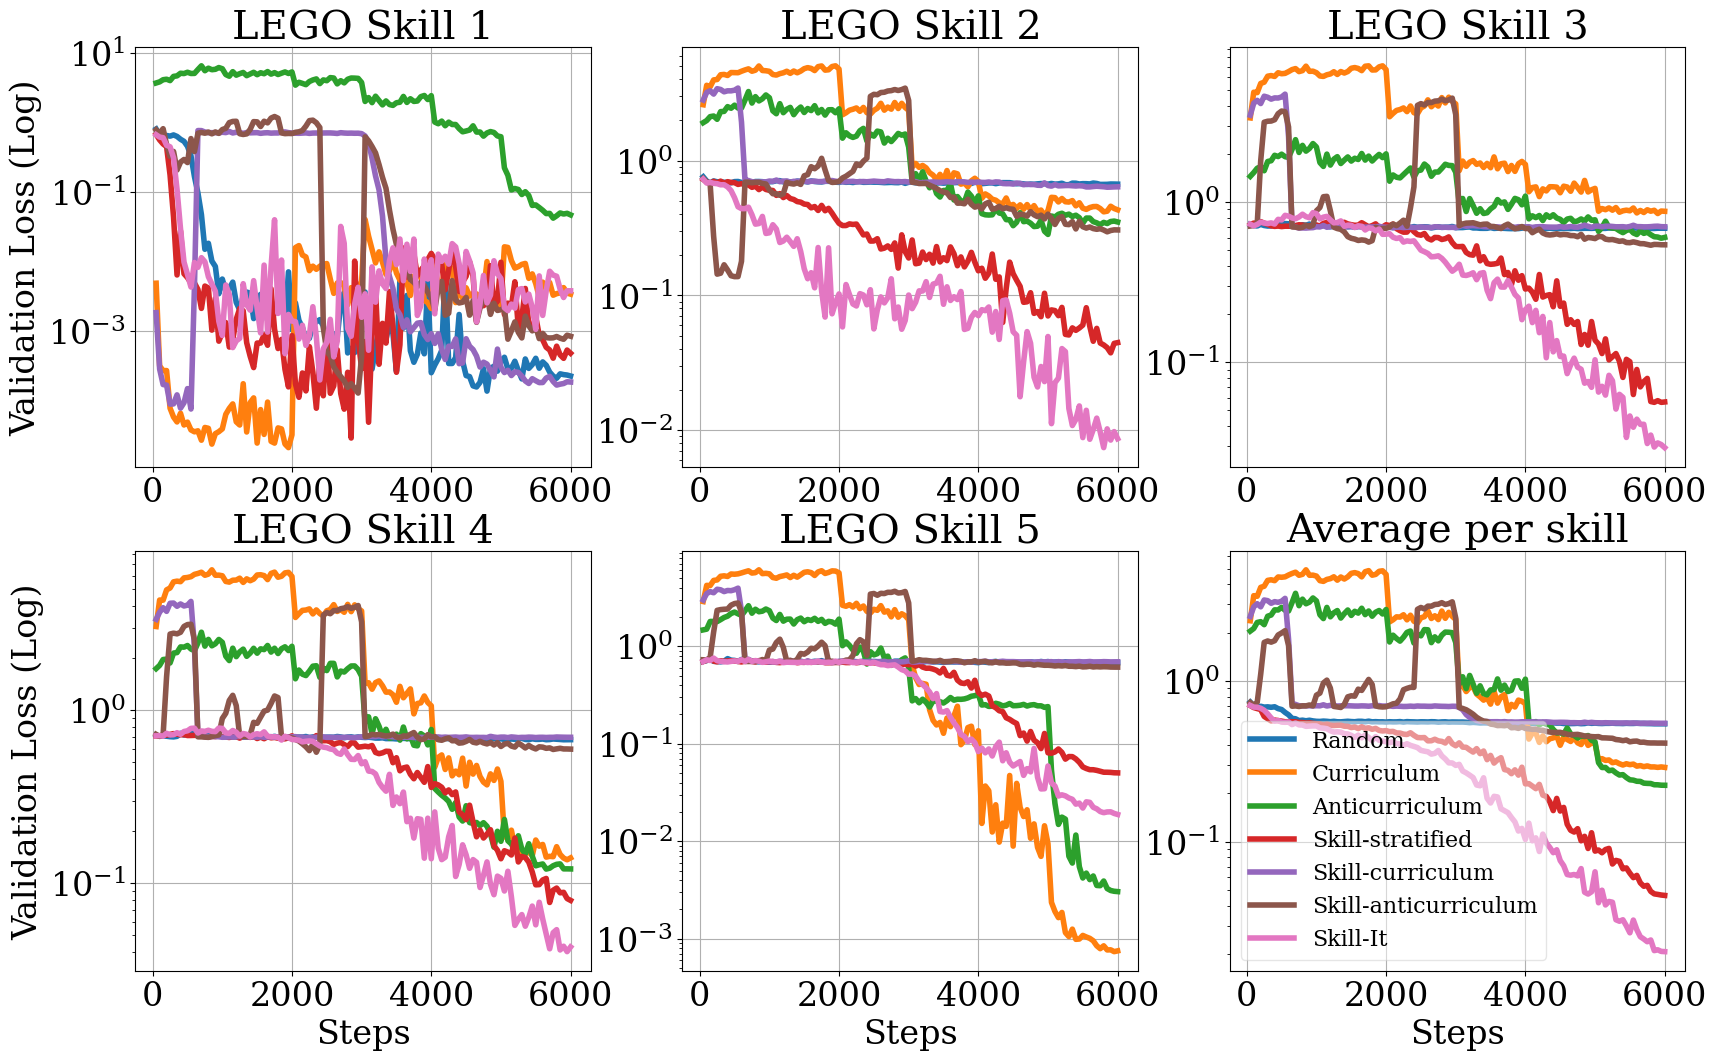

In [9]:
n_var = 5 + 1

nrow = 2
ncol = int(np.ceil(n_var / nrow))
print(nrow, ncol)

figure, axis = plt.subplots(nrow, ncol, figsize=(20, 12))


methods = [ "lego_5_192000_mixture_weights_11135_static", 
           "lego_5_curriculum_192000_mixture_weights_11135_static",
           "lego_5_anticurriculum_192000_mixture_weights_11135_static",
           "lego_5_6000_stratified_static",
           "lego_5_group_curriculum_mixingfrac_0.0_192000_stratified_static",
           "lego_5_group_anticurriculum_mixingfrac_0.0_192000_stratified_static",
           "lego_5_6000_mixture_graph_1000011110001000001000001_greedy_1000_eta_0.5_lookback_3"
]

labels = [ "Random", "Curriculum", "Anticurriculum", "Skill-stratified", "Skill-curriculum", "Skill-anticurriculum", "Skill-It"]



for k, method in enumerate(methods):

    df_weighted = df_all.loc[df_all.method ==  method].sort_index()
    print(df_weighted.seed.unique())
    
    if method == "192000":
        filtered_idxs = np.arange(0, 6060, 60)
        df_weighted = df_weighted.loc[df_weighted.index.isin(filtered_idxs)]

    #df_weighted = df_weighted.loc[df_weighted.seed == seed]
    df_weighted_overall =  df_weighted.groupby([df_weighted.index]).apply(lambda x: aggregate_task_category(x, ppl=False)).reset_index()
    df_weighted_overall.set_index("checkpoint", inplace=True)
    if df_weighted_overall.index.min() == 0:
        df_weighted_overall.drop([0], inplace=True)

    df_weighted = df_weighted.groupby([df_weighted.index, "skill"]).apply(lambda x: aggregate_task_category(x, ppl=False)).reset_index()
    df_weighted.set_index("checkpoint", inplace=True)

    task_idxs = df_weighted.skill.unique()

    for idx, t in enumerate(task_idxs):
        i = int(idx / ncol)
        j = int(idx % ncol)
        #plt.figure()
        df_task_weighted = df_weighted.loc[(df_weighted.skill == t) & (df_weighted.index > 0)]
        
        
        #axis[i, j].fill_between(df_task.index, df_task.task_loss - df_task.stddev, df_task.task_loss + df_task.stddev, alpha=0.2)

        df_task_weighted.task_loss.plot(legend=False, label=labels[k], ax=axis[i, j], lw=4)
        #axis[i, j].fill_between(df_task_weighted.index, df_task_weighted.task_loss - df_task_weighted.stddev, df_task_weighted.task_loss + df_task_weighted.stddev, alpha=0.2)

        axis[i, 0].set_ylabel("Validation Loss (Log)")

        axis[i, j].set_title(f"LEGO Skill {int(t+1)}")
        
        axis[i, j].grid()
        
        # axis[i, j].set_ylim(-0.05, 0.8)
        
        if i != -1:
            axis[i, j].set_xlabel("")
        axis[-1, j].set_xlabel("Steps")
        
        axis[i, j].set_yscale("log")
        
        # axis[i, j].legend(loc="upper right")


    idx += 1
    i = int(idx / ncol)
    j = int(idx % ncol)
    df_weighted_overall.task_loss.plot(legend=True, label=labels[k], ax=axis[i,j], lw=4)
    axis[i, j].set_title("Average per skill")
    axis[i, j].set_xlabel("Steps")
    axis[i, j].grid()
    
    axis[i, j].set_yscale("log")
    
    axis[i, j].legend(loc = "lower left", fontsize=16, fancybox=True, framealpha=0.5)



# plt.savefig("../figs/lego_mw_large_font.pdf", bbox_inches="tight")

In [10]:
for method in methods:
    print(f"Method: {method}")
    df_weighted = df_all.loc[df_all.method ==  method].sort_index()
    df_weighted = df_weighted.groupby([df_weighted.index, "skill", "seed"]).apply(lambda x: aggregate_task_category(x, ppl=False)).reset_index()
    df_weighted.set_index("checkpoint", inplace=True)
    
    idx_nearest_to_k = np.abs(df_weighted.index.unique() - 6000).argsort()[0]
    
    print(f"Seeds: {df_weighted.seed.unique()}")

    print(f"Average loss per skill: {df_weighted.loc[df_weighted.index == df_weighted.index.unique()[idx_nearest_to_k]].groupby('skill').task_loss.mean()}")
    print(f'Standard deviation per skill: {df_weighted.loc[df_weighted.index == df_weighted.index.unique()[idx_nearest_to_k]].groupby("skill").task_loss.std()}')
    print(f'Overall average loss: {df_weighted.loc[df_weighted.index == df_weighted.index.unique()[idx_nearest_to_k]].groupby("seed").task_loss.mean().mean()}')
    print(f'Overall standard deviation: {df_weighted.loc[df_weighted.index == df_weighted.index.unique()[idx_nearest_to_k]].groupby("seed").task_loss.mean().std()}')



Method: lego_5_192000_mixture_weights_11135_static
Seeds: [0 1 2 3 4]
Average loss per skill: skill
0    0.000227
1    0.669098
2    0.686100
3    0.675555
4    0.678487
Name: task_loss, dtype: float64
Standard deviation per skill: skill
0    0.000063
1    0.051008
2    0.013174
3    0.045506
4    0.032479
Name: task_loss, dtype: float64
Overall average loss: 0.5418937557769896
Overall standard deviation: 0.028403148572690794
Method: lego_5_curriculum_192000_mixture_weights_11135_static
Seeds: [0 1 2 3 4]
Average loss per skill: skill
0    0.003404
1    0.431495
2    0.875430
3    0.140106
4    0.000751
Name: task_loss, dtype: float64
Standard deviation per skill: skill
0    0.002001
1    0.027861
2    0.051163
3    0.022579
4    0.000325
Name: task_loss, dtype: float64
Overall average loss: 0.29023702286763486
Overall standard deviation: 0.008251546009751608
Method: lego_5_anticurriculum_192000_mixture_weights_11135_static
Seeds: [0 1 2 3 4]
Average loss per skill: skill
0    0.046762

In [3]:
df_all_preds = pd.DataFrame()

for perp_folder in perp_folders:
    files = os.listdir(perp_folder)
    files = [os.path.join(perp_folder, f) for f in files] # add path to each file
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    
    for file in files: 
        if "log" in file:
            continue 
        method = file.split("/")[-1]
        runs = os.listdir(file)
        for run in runs:
            if "prediction" not in run:
                continue 
            seed = int(run.split("seed_")[-1].split("_")[0])
            checkpoint = int(run.split("-")[-1].split(".")[0])
            if len(df_all_preds) != 0:
                if len(df_all_preds.loc[(df_all_preds.method==method) & (df_all_preds.seed == seed) & (df_all_preds.index==checkpoint)]) != 0:
                    #print(f"already exists: {method}, {seed}, {checkpoint}")
                    continue 
                
            path = os.path.join(file, run)
            print(path)
                
            pred_dict = pd.read_pickle(path)
        

        
            df = pd.DataFrame([{"skill": k, "prediction": [values.numpy() if torch.is_tensor(values) else values for values in v]} for k, v in pred_dict.items()])
            df["method"] = method
            df["seed"] = seed
            df["checkpoint"] = checkpoint


            df.set_index("checkpoint", inplace=True)


            df_all_preds = pd.concat([df_all_preds, df])
    
#df_all.set_index("checkpoint", inplace=True)
#df_all = df_all.sort_index()

../output/10162023/lego_5_anticurriculum_192000_mixture_weights_11135_static/seed_4_predictions_checkpoint-4900.pkl
../output/10162023/lego_5_anticurriculum_192000_mixture_weights_11135_static/seed_2_predictions_checkpoint-3150.pkl
../output/10162023/lego_5_anticurriculum_192000_mixture_weights_11135_static/seed_4_predictions_checkpoint-2600.pkl
../output/10162023/lego_5_anticurriculum_192000_mixture_weights_11135_static/seed_0_predictions_checkpoint-5000.pkl
../output/10162023/lego_5_anticurriculum_192000_mixture_weights_11135_static/seed_3_predictions_checkpoint-5100.pkl
../output/10162023/lego_5_anticurriculum_192000_mixture_weights_11135_static/seed_4_predictions_checkpoint-1250.pkl
../output/10162023/lego_5_anticurriculum_192000_mixture_weights_11135_static/seed_0_predictions_checkpoint-400.pkl
../output/10162023/lego_5_anticurriculum_192000_mixture_weights_11135_static/seed_4_predictions_checkpoint-750.pkl
../output/10162023/lego_5_anticurriculum_192000_mixture_weights_11135_stat

In [5]:
# need to adjust perp folder but there should be a labels saved somewhere 
methods = [ "lego_5_192000_mixture_weights_11135_static", 
           "lego_5_curriculum_192000_mixture_weights_11135_static",
           "lego_5_anticurriculum_192000_mixture_weights_11135_static",
           "lego_5_6000_stratified_static",
           "lego_5_group_curriculum_mixingfrac_0.0_192000_stratified_static",
           "lego_5_group_anticurriculum_mixingfrac_0.0_192000_stratified_static",
           "lego_5_6000_mixture_graph_1000011110001000001000001_greedy_1000_eta_0.5_lookback_3"
]

labels = [ "Random", "Curriculum", "Anticurriculum", "Skill-stratified", "Skill-curriculum", "Skill-anticurriculum", "Skill-It"]

file = "../output/10172023/lego_5_6000_stratified_static/"
label_dict = pd.read_pickle(file+"/labels.pkl")
label_df = pd.DataFrame([{"skill": k, "label": [values.numpy() if torch.is_tensor(values) else values for values in v]} for k, v in label_dict.items()])

for method in methods:
    print(method)
    df = df_all_preds.loc[df_all_preds.method == method].sort_index()
    df['accs'] = df.apply(lambda x: (np.array(x.prediction) == np.array(label_df.loc[label_df.skill == x.skill].label.values[0])).mean(), axis=1)
    
    idx_nearest_to_k = np.abs(df.index.unique() - 6000).argsort()[0]
    
    df_ckpt = df.loc[df.index==df.index.unique()[idx_nearest_to_k]]
    
    print(df_ckpt.seed.unique())
    
    print(df_ckpt.groupby("skill").accs.mean())
    print(df_ckpt.groupby("skill").accs.std())
    print(df_ckpt.groupby("seed").accs.mean().mean())
    print(df_ckpt.groupby("seed").accs.mean().std())

    #print(df.loc[df.index.max()].accs.mean())
# df['accs'] = df.apply(lambda x: np.array([1 if pred == x.task_idx else 0 for pred in x.prediction ]).mean(), axis=1)  

lego_5_192000_mixture_weights_11135_static
[2 1 4 0 3]
skill
0    1.000
1    0.538
2    0.574
3    0.482
4    0.512
Name: accs, dtype: float64
skill
0    0.000000
1    0.067602
2    0.054589
3    0.061400
4    0.042661
Name: accs, dtype: float64
0.6212
0.034571664698131055
lego_5_curriculum_192000_mixture_weights_11135_static
[4 1 3 0 2]
skill
0    1.000
1    0.802
2    0.496
3    0.970
4    1.000
Name: accs, dtype: float64
skill
0    0.000000
1    0.013038
2    0.029665
3    0.023452
4    0.000000
Name: accs, dtype: float64
0.8535999999999999
0.006841052550594832
lego_5_anticurriculum_192000_mixture_weights_11135_static
[4 0 1 3 2]
skill
0    0.988
1    0.846
2    0.680
3    0.968
4    1.000
Name: accs, dtype: float64
skill
0    0.013038
1    0.030496
2    0.069282
3    0.013038
4    0.000000
Name: accs, dtype: float64
0.8964000000000001
0.018514858897652968
lego_5_6000_stratified_static
[4 3 1 2 0]
skill
0    1.000
1    0.982
2    0.982
3    0.978
4    0.982
Name: accs, dtype: float6

In [6]:
# need to adjust perp folder but there should be a labels saved somewhere 


for method in methods:
    print(method)
    df = df_all_preds.loc[df_all_preds.method == method].sort_index()
    df['accs'] = df.apply(lambda x: (np.array(x.prediction) == np.array(label_df.loc[label_df.skill == x.skill].label.values[0])).mean(), axis=1)
    
    idx_nearest_to_k = np.abs(df.index.unique() - 3000).argsort()[0]
    
    df_ckpt = df.loc[df.index==df.index.unique()[idx_nearest_to_k]]
    
    print(df_ckpt.seed.unique())
    
    print(df_ckpt.groupby("skill").accs.mean())
    print(df_ckpt.groupby("skill").accs.std())
    print(df_ckpt.groupby("seed").accs.mean().mean())
    print(df_ckpt.groupby("seed").accs.mean().std())

    #print(df.loc[df.index.max()].accs.mean())
# df['accs'] = df.apply(lambda x: np.array([1 if pred == x.task_idx else 0 for pred in x.prediction ]).mean(), axis=1)  

lego_5_192000_mixture_weights_11135_static
[0 3 4 2 1]
skill
0    1.000
1    0.522
2    0.508
3    0.472
4    0.472
Name: accs, dtype: float64
skill
0    0.000000
1    0.040866
2    0.045497
3    0.019235
4    0.094710
Name: accs, dtype: float64
0.5948
0.005761944116355171
lego_5_curriculum_192000_mixture_weights_11135_static
[1 4 0 3 2]
skill
0    1.000
1    0.598
2    0.400
3    0.508
4    0.666
Name: accs, dtype: float64
skill
0    0.000000
1    0.033466
2    0.017321
3    0.031145
4    0.087920
Name: accs, dtype: float64
0.6344000000000001
0.026053790511171328
lego_5_anticurriculum_192000_mixture_weights_11135_static
[0 4 3 2 1]
skill
0    0.142
1    0.642
2    0.662
3    0.662
4    0.852
Name: accs, dtype: float64
skill
0    0.030332
1    0.037014
2    0.030332
3    0.029496
4    0.052631
Name: accs, dtype: float64
0.592
0.03133687923198479
lego_5_6000_stratified_static
[3 0 2 4 1]
skill
0    1.000
1    0.940
2    0.706
3    0.592
4    0.556
Name: accs, dtype: float64
skill
0    0

In [16]:
checkpoints = np.arange(0, 6050, 50)
checkpoints_2 = np.arange(0, 6060, 60)


2 3
[3 4 0 2 1]
[0 3 4 2 1]
[1 2 4 0 3]
[1 3 0 4 2]
[4 0 3 1 2]
[3 4 2 0 1]
[0 4 2 3 1]


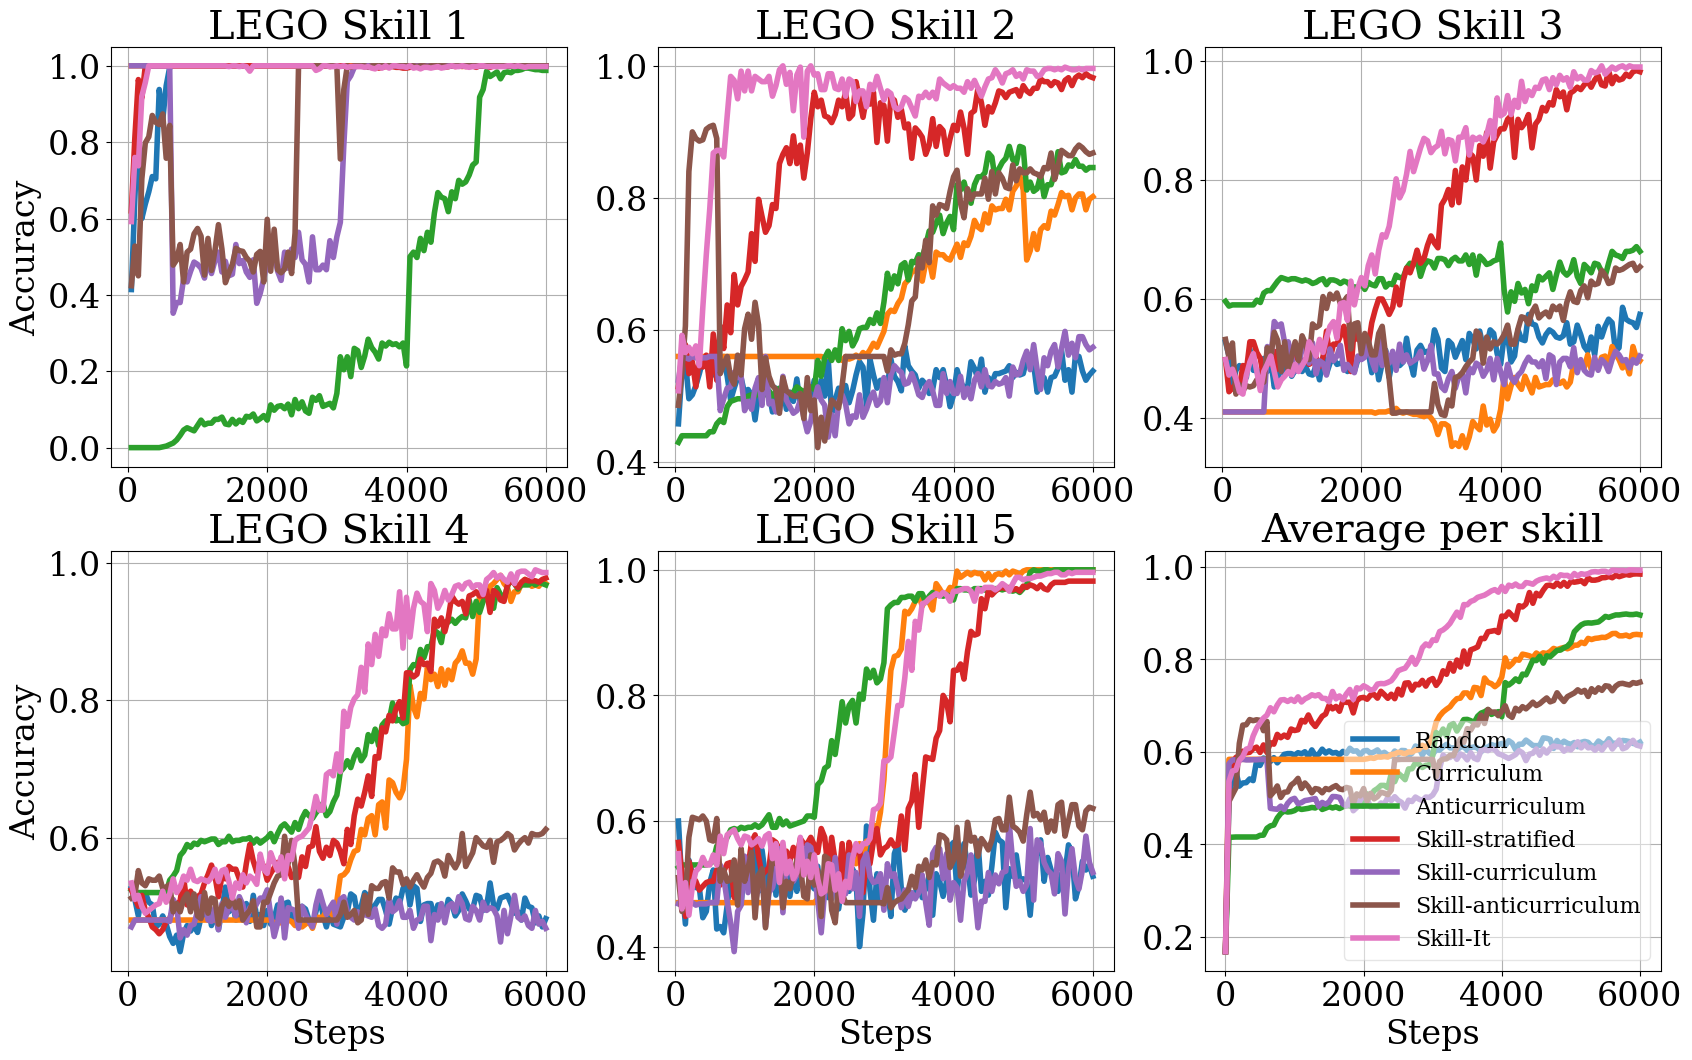

In [22]:
n_var = 5 + 1

nrow = 2
ncol = int(np.ceil(n_var / nrow))
print(nrow, ncol)

figure, axis = plt.subplots(nrow, ncol, figsize=(20, 12))


labels = ["Random", "Curriculum", "Anticurriculum", "Skill-stratified", "Skill-curriculum", "Skill-anticurriculum", "Skill-It"]


for k, method in enumerate(methods):

    df_weighted = df_all_preds.loc[df_all_preds.method ==  method].sort_index()
    print(df_weighted.seed.unique())

    #df_weighted = df_weighted.loc[df_weighted.seed == seed]
    
    
    
    
    df_weighted['accs'] = df_weighted.apply(lambda x: (np.array(x.prediction) == np.array(label_df.loc[label_df.skill == x.skill].label.values[0])).mean(), axis=1)        
        
    task_idxs = sorted(df_weighted.skill.unique())
    
    df_weighted_overall = df_weighted.groupby(df_weighted.index)['accs'].mean()

    for idx, t in enumerate(task_idxs):
        i = int(idx / ncol)
        j = int(idx % ncol)
        #plt.figure()
        df_task_weighted = df_weighted.loc[(df_weighted.skill == t) & (df_weighted.index > 0)]
        
        df_task_weighted.groupby(df_task_weighted.index).accs.mean().plot(
            legend=False, label=labels[k], ax=axis[i, j], lw=4
        )

        #axis[i, j].fill_between(df_task.index, df_task.task_loss - df_task.stddev, df_task.task_loss + df_task.stddev, alpha=0.2)

        # df_task_weighted.task_loss.plot(legend=False, label=labels[k], ax=axis[i, j], lw=3)
        #axis[i, j].fill_between(df_task_weighted.index, df_task_weighted.task_loss - df_task_weighted.stddev, df_task_weighted.task_loss + df_task_weighted.stddev, alpha=0.2)

        axis[i, 0].set_ylabel("Accuracy")

        axis[i, j].set_title(f"LEGO Skill {int(t+1)}")
        
        axis[i, j].grid()
        
        # axis[i, j].set_ylim(-0.05, 0.8)
        
        if i != -1:
            axis[i, j].set_xlabel("")
        axis[-1, j].set_xlabel("Steps")
        
        
        # axis[i, j].legend(loc="upper right")


    idx += 1
    i = int(idx / ncol)
    j = int(idx % ncol)
    df_weighted_overall.plot(
            legend=False, label=labels[k], ax=axis[i, j], lw=4
    )
    axis[i, j].set_title("Average per skill")
    axis[i, j].set_xlabel("Steps")
    axis[i, j].grid()
    
    
    axis[i, j].legend(fontsize="16", loc = "lower right", fancybox=True, framealpha=0.5)



plt.savefig("../figs/lego_accs_large_font.pdf", bbox_inches="tight")